# Deep Reinforcement Learning Classification

## Import Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

## Parameters

In [4]:
data_path = '/Users/cesar.salcedo/Documents/datasets/mnist'

## Dataset

In [5]:
ts = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(0., 1.),
])

data = torchvision.datasets.MNIST(data_path, transform=ts)
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=2)

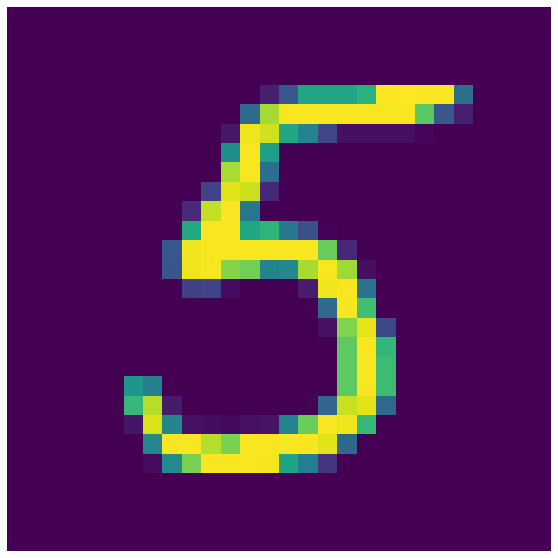

In [6]:
batch = next(iter(data_loader))

x = batch[0][0].squeeze()

fig = plt.figure(figsize=(13, 10))
plt.axis('off')
plt.imshow(x)
plt.show()
plt.close(fig)

## Environment

In [13]:
class ImageClassificationEnv():
    def __init__(self, m, threshold=0.9, time_diff=1.):
        super(ImageClassificationEnv, self).__init__()
        
        self.m = m                        # Number of pixels in a side of an image. Hence observations are m x m sized matrices
        self.time_diff = float(time_diff)
        self.threshold = threshold
        
        # Dataset parameters
        self.data = torchvision.datasets.MNIST(data_path, transform=transforms.PILToTensor())
        
        sample = self.data[0]
        x, y = sample
        
        _, h, w = x.shape
        
        self.transform = transforms.Compose([
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float),
            transforms.Normalize(0., 1.),
            transforms.Pad([w, h]),
        ])
        
        self.data.transform = self.transform
        
        self.data_loader = torch.utils.data.DataLoader(self.data,
                                                       batch_size=1,
                                                       shuffle=True,
                                                       num_workers=2)
        
        # Note: Padding taken into account
        self.w = 3 * w
        self.h = 3 * h
        
        x_max = w            # Right end
        x_min = -x_max       # Left end
        y_max = h            # Top end
        y_min = -y_max       # Bottom end
        zoom_max = 10        # Front end
        zoom_min = -10       # Back end
        
        self.box = torch.Tensor([
            [x_min, y_min, zoom_min],
            [x_max, y_max, zoom_max]
        ])
        
        self.action_space_box = torch.Tensor([
            [-1, -1, -1],
            [1, 1, 1]
        ])
        
        self.iter = self.sample = self.position = self.velocities = None
        
        self.reset()
    
    
    def reset(self):
        self.iter = iter(self.data_loader)
        
        # Have next observation ready
        self._next_image()
        
        # Have agent state ready
        self.position = torch.zeros(3)
        self.velocities = torch.zeros(3)
    
    def step(self, action):
        accel, guess = action
        
        accel = torch.minimum(torch.maximum(accel, self.action_space_box[0]), self.action_space_box[1])
        
        self.velocities += accel * self.time_diff
        self.position += self.velocities * self.time_diff
        
        # Bound position to valid area
        self.position = torch.minimum(torch.maximum(self.position, self.box[0]), self.box[1])
        
        
        self.prediction += guess * self.time_diff
        self.prediction /= self.prediction.sum()
        
        if self.prediction.max() >= self.threshold:
            if self.prediction.argmax() == self.label[0]:
                reward = 10
            else:
                reward = -10
                
            self._next_image()
        else:
            reward = 0
        
        next_state = self.get_view(self.position)
        
        done = self.sample == None
            
        return next_state, reward, done
        
    def get_view(self, pos):
        # Bound point to positioning box
        bounded_pos = torch.minimum(torch.maximum(pos, self.box[0]), self.box[1])
        
        x, y, zoom = bounded_pos
        (x_min, y_min, zoom_min), (x_max, y_max, zoom_max) = self.box
        h_min, h_max = min(self.w, self.h) / 3, self.m
        
        scaled_zoom = torch.round(np.exp((np.log(h_min) * (zoom_max - zoom) + np.log(h_max) * (zoom - zoom_min)) / (zoom_max - zoom_min))).int()
        x_left = torch.round(self.w / 2 - scaled_zoom / 2 + x).int()
        y_top = torch.round(self.h / 2 - scaled_zoom / 2 - y).int()
        
        obs = transforms.functional.resized_crop(self.image, y_top, x_left, scaled_zoom, scaled_zoom, self.m)
        
        return obs
    
    def _next_image(self):
        # Have next observation ready
        self.sample = next(self.iter, None)
        
        if self.sample == None:
            self.iter = iter(self.data_loader)
            self.sample = next(self.iter, None)
            
        self.image = self.sample[0]
        self.label = self.sample[1]
        
        # Have agent state ready
        self.prediction = torch.ones(10) * 0.5
    

In [14]:
env = ImageClassificationEnv(12)

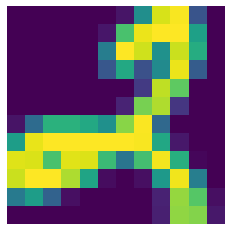

In [15]:
x = env.get_view(torch.Tensor([0,  0,  0]))
fig = plt.figure()
plt.axis('off')
plt.imshow(x.squeeze())
plt.show()
plt.close(fig)

t:   4%|▍         | 4/90 [00:00<00:02, 35.03it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


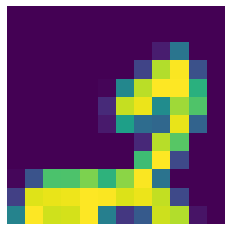

In [16]:
import math

fig, ax = plt.subplots()

duration = 6
fps = 15

def make_frame(t):
    x = env.get_view(torch.Tensor([5 * math.sin(4 * 3.1416 * t / duration), 5 * math.cos(4 * 3.1416 * t / duration), 10 * math.sin(2 * 3.1416 * t / duration)]))[0, 0]
    
    ax.clear()
    
    ax.axis('off')
    ax.imshow(x.squeeze())
    
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration = duration)
animation.ipython_display(fps = fps, loop = True, autoplay = True)

t:   6%|▌         | 5/90 [00:00<00:02, 40.18it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


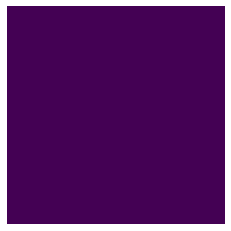

In [17]:
env.reset()


# Make video
fig, ax = plt.subplots()

duration = 6
fps = 15

rewards = []

def make_frame(t):
    accel = torch.randn(3) * 0.05
#     accel = torch.Tensor([0.1 * math.sin(4 * 3.1416 * t / duration) - 0.05, 0.1 * math.cos(4 * 3.1416 * t / duration) - 0.05, math.sin(2 * 3.1416 * t / duration) / 2 + 0.5])

#     guess = torch.Tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
#     guess = torch.ones(10) * 0.1
    guess = torch.randn(10)
    guess /= guess.sum()
    
    next_state, reward, done = env.step([accel, guess])
    
    rewards.append(reward)
    
    ax.clear()
    
    ax.axis('off')
    ax.imshow(next_state.squeeze())
    
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration = duration)
animation.ipython_display(fps = fps, loop = True, autoplay = True)

In [18]:
print(rewards)
print(np.array(rewards).max())

[-10, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, -10, 0, 0, 0, -10, 0, 0, -10, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 10, 0, 0, -10, 0, 0, 0, 0, 0]
10


## Learning model